# k-Nearest Neighbor (kNN)

Implementierte Sie den kNN-Klassifikator basierend auf folgenden Arbeitsschritten: 

- Laden des Datensatzes und aufteilen in Trainings- und Testdaten.
- Erinnern der Daten in der Trainingsphase 
- Vergleichen jedes Testbilds mit allen erinnerten Trainingsbildern in der Vorhersage-Phase und übernehmen des Klassennamens, der `k` ähnlichsten Trainingsbeispiele
- Ermitteln des besten `k` durch Kreuzvalidierung
- Darstellen der nächsten `k` Trainingsbilder zu je einem Testbild aus jeder Klasse

Einige Aufgaben sind nicht notwendig, sodass Sie ein insgesamt läuffahiges Notebook erhalten.

## Initialisierungen

In [1]:
# Initialization of some basic modules and global parameters

# imports
import random
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

# Plot figures inline and set some global parameters for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

## Datensatzinitialisierung und -aufbereitung

Bei dem Datensatz, den Sie klassifizieren sollen, handelt es sich um den [Cifar10-Datensatz](https://www.cs.toronto.edu/~kriz/cifar.html). Grundsätzlich handelt es sich dabei um kleine Bilder, die in zehn Klassen unteteilt sind. Machen Sie sich mit dem Aufbau vertraut. 

In [2]:
def load_CIFAR_batch(filename):
    """
    Opens and decodes a single batch of the cifar10 dataset.

    Input: 
    - A string containing the absolute path to a batch file
    
    Output:
    - An array containing the data
    - An array containing the labels 
    """
    # 'rb' stands for read binary
    with open(filename, 'rb') as f:      
        #####################################################################
        # TODO (2):                                                         #
        # Use pickle.load() to read the cifar10 data into a dictonary.      #
        # Create a parameter X for the image data and a parameter Y for the #
        # labels.                                                           #
        #####################################################################
        datadict = pickle.load(f, encoding='bytes')
        X = datadict.pop(b'data')
        Y = datadict.pop(b'labels')
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################        
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(root_folder):
    """
    Load training and test data of the cifar10 dataset into arrays.

    Input: 
    - A string containing the absolute path to the cifar 10 dataset folder
    
    Output:
    - Array containing the image data for the trainings set
    - Array containing the image labels for the trainings set
    - Array containing the image data for the test set
    - Array containing the image labels for the test set
    """ 
    xs = []
    ys = []
    
    # Load and decode each batch of the trainings set
    for batch in range(1,6):
        f = os.path.join(root_folder, 'data_batch_%d' % (batch, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    # Create one ndarray from the single batches for data and labels
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    # Load and decode test data and labels  
    Xte, Yte = load_CIFAR_batch(os.path.join(root_folder, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
#####################################################################
# TODO (0):                                                         #
# Download the Cifar10 Python version into your directroy, unzip    #
# and point to it.                                                  #                                                             
#####################################################################
cifar10_dir = 'ak1163051/datasets/cifar-10-batches-py'  # default dir
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Zur Kontrolle, ob die Daten korrekt geladen wurden und zur Veranschaulichung, implementieren Sie eine Visualisierung von `x` **zufälligen** Beispielbilder für jede Klasse des Cifar10-Datensatzes aus der Trainingsmenge mit dem Label als Spaltenüberschrift ohne sichtbare Achsen, hier ein Beispiel:
<img src="ak1163051/pics/cifar10_sampleplot.png", width=600>

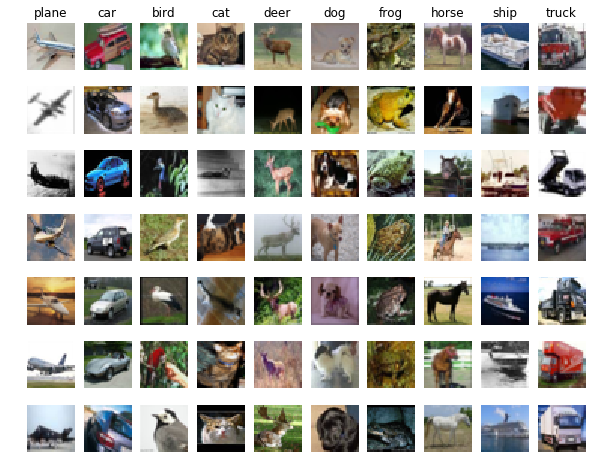

In [3]:
# Plot k random examples of training images from each class.
# Answer: 
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
#####################################################################
# TODO (3):                                                         #
# Plot a figure where the colums are equal to the number of classes #
# and rows are defined by the number of samples per class. Each     #
# sample should be a random image from training data. Add class     #
# labels as title and remove axis from the figure.                  #
#                                                                   #
# Hint: Keep an eye on the cifar10 data encoding.                   # 
#####################################################################
f, axarr = plt.subplots(7, 10)
for i in range(num_classes):
    indices = np.where( y_train==i )
    axarr[0,i].set_title(classes[i])
    for j in range(samples_per_class):
        index = indices[0][random.randint(0, len(indices[0])-1)]
        axarr[j,i].imshow(X_train[index].astype('uint8'))
        axarr[j,i].axis('off')
        
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

Um die Kalkulation des Klassifikators zu reduzieren, verwenden Sie für die Berechnung nur eine Teilmenge der Traings- bzw. Testdaten. Ferner müssen die Bilddaten für die weitere Verarbeitung so umgeformt werden, dass aus der drei dimensionalen Bilddarstellung einen ein dimensionale wird.

In [4]:
# Subsample trainings data 
num_training = 5000
mask = range(num_training)

X_train = X_train[mask]
y_train = y_train[mask]

# Subsample test data 
num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape each image data into a 1-dim array
print (X_train.shape, X_test.shape) # Should be: (5000, 32, 32, 3) (500, 32, 32, 3)

#####################################################################
# TODO (2):                                                         #
# Reshape the image data to one dimension.                          #
#                                                                   #
# Hint: Look at the numpy reshape function and have a look at -1    # 
#       option                                                      #
#####################################################################
X_train = np.reshape(X_train, (num_training, -1))
X_test = np.reshape(X_test, (num_test, -1))
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

print (X_train.shape, X_test.shape) # Should be: (5000, 3072) (500, 3072)

(5000, 32, 32, 3) (500, 32, 32, 3)
(5000, 3072) (500, 3072)


## Training und Klassifikation mit kNN

Der `kNN`-Klassifikator ist in einem eignen Skript untergebracht, sodass der Klassifikator in dem Workflow austauschbar ist. Zunächst muss dieser also initialisiert werden. Das Training eines kNN ist - verglichen mit neurolanen Netzwerken - trivial. Der Klassifikator speichert die Daten für sich ab und macht in der Trainingsphase nichts weiteres. 

In [5]:
from ak1163051 import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Der entscheidene Schritt beim `kNN`-Klassifikator passiert während der Klassifikation selbst. Wie oben kurz erwähnt, wird ein Testbild gegen die Trainingsbilder vergleichen und dies in Abhängigkeit von einer Variablen `k`. Der folgende Prozess lässt sich in zwei Kernschritte zerlegen:

- Berechnung der Distanzen von jedem Testbild zu allen Trainingsbildern.
- Finden der `k` geringsten Distanzen zu dem jeweiligen Testbild und vergeben der resultierenden Klasse.

Um den Trainingsprozess umzusetzten, öffnen Sie das Skript `k_nearest_neighbor.py` im Ordner `/ak1163051/classifiers` und Implementieren Sie die Funktion `compute_distances_with_loops`. Hier soll eine Matrix mit dem [Euklidischer Abstand](https://en.wikipedia.org/wiki/Euclidean_distance) (L2) zwischen allen Trainingsdaten und Testdaten erzeugt werden. Die Umsetzung erfolgt durche eine doppelte Schleife, die über alle Elemente iteriert und den jeweiligen Abstand berechnet. Diese Variante ist offensichtlich nicht sehr effizient und kann bei großen Datensätzen zu Problemen führen.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dc0281a964ec758cca02ab9ef91a7f54ac00d4b7", width=600>
`d := sqrt(dot(a-b,a-b))`

In [6]:
# Before running this cell: open `ak1163051/k_nearest_neighbor.py` and 'implement compute_distances_with_loops`

# Compute the distance between the test data and trainings data
dists = classifier.compute_distances_with_loops(X_test)
print(dists.shape) # Should be: (500, 5000)

euclidean distance calculation: 100%|██████████| 500/500 [00:18<00:00, 26.34it/s]

(500, 5000)


Ein eleganterer und effizienterer Weg die Distanzberechnung zu implementieren wird durch die Vektordarstellung der Daten ermöglicht, welche Sie vorher umgesetzt haben. Durch [Vektorisierung](https://en.wikipedia.org/wiki/Array_programming) wird eine Operation nicht nur auf einem Element sondern auf jedem Element eines Arrays ausgeführt. Die Distanzberechung kann in diesem Fall deutlich effizienter gestaltet werden und ermöglichen die Teilmenge, welche Sie ausgewählt haben, zu erhöhen. Neurale Netzwerke können nur aufgrund dieser Technik gut berechnet werden, da der Aufwand sonst zu hoch wäre. Implementieren Sie die Funktion `compute_distances_vectorized` im Skript. Obwohl diese Aufgabe nicht optional ist, ist Sie nicht notwendig um fortzufahren. Sofern, die Aufgabe zu komplex ist, fahren Sie erst einmal fort oder bearbeiten andere Aufgaben als ausgleich.  

In [6]:
# This task is not vital for the notebook. Run that cell only if you have implement the vectorized function
dists_vec = classifier.compute_distances_vectorized(X_test)
dists = dists_vec
# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_vec, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Der erste Kernschritt war damit abgearbeitet. Es bleibt nun die geringsten Distanzen zu finden und eine resultierdende Klasse auszuwählen. Implementieren in dem Skript hierzu die Funktion `predict.labels()`.

In [7]:
# Before running this cell: implement the function predict_labels
y_test_pred = classifier.predict_labels(dists)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Dies sollte ein Ergebnis von ungefähr `27,4%` Genauigkeit erzielen. Das Aufrufen der Methode `predict.labels()` ohne spezifischen Parameter `k` hat als Standardwert `k=1` gesetzt und somit nur den direkten Nachbarn betrachtet. Wiederholen Sie die Klassifikation mit `k` gleich fünf.

In [8]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


Dies hat eine kleine Verbesserung gebracht. Per Hand mögliche Optionen von `k` zu testen ist jedoch nicht sonderlich effizient. Im Folgenden versuchen Sie dies zu automatisieren.

## Kreuzvalidierungsverfahren

Sie haben bereits den kNN-Klassifikator implementiert, jedoch in Bezug auf das Ergebnis nicht optimiert. Das Kreuzvalidierungsverfahren ([cross-validation](https://en.wikipedia.org/wiki/Cross-validation)) bietet eine Möglichkeit Optionen automatisiert zu testen und zu vergleichen. Im Rahmen von Machine Learning handelt es sich bei diesem Vorgehen im Allgemeinen um eine Hyperparameter-Optimalisierung (als Methode wird hier Kreuzvalidierungsverfahren verwendet). Es werden alle veränderlichen Werte einer Methode versucht so einzustellen, dass das beste Ergebnis erzielt wird. Implementieren tun Sie eine k-fold cross-validation:

>**k-fold cross-validation**

>In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used,[6] but in general k remains an unfixed parameter.

>When k = n (the number of observations), the k-fold cross-validation is exactly the leave-one-out cross-validation.

>In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO (2):                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
#                                                                              #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = 
y_train_folds = 
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO (5):                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Erstellen Sie ein Scatter-Plot der die Genauigkeiten für die in der Kreuzvalidierung verwendeten `k` visualisiert. Bestimmen Sie dabei für jeden `k`-Wert sowohl das arithmetische Mittel als auch die Standardabweichung. Der Plot könnte so aussehen:
<img src="ak1163051/pics/k-fold-cross-validation.png", width=600>

In [ ]:
################################################################################
# TODO (2):                                                                    #
# Create an scatter plot for each k in k_choices that plots the accuracies.    #
# Calculate the mean and standard deviation for the accuracies of each k and   #
# add them to the plot.                                                        #
#                                                                              #
# Hint: Numpy provides mean() and std() as functions, use them. You can either #
#       use matplotlibs errorbar function to plot the mean and standard        # 
#       deviation based on k_choices.                                          #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Berechnen Sie ein kNN-Klassifikator mit dem Hyperparameter k, der sich aus der Kreuzvalidierung ergeben hat, auf den gesamten Datensatz und geben Sie zur je einer Klasse ein Testbild mit den nächsten Nachbarn aus. Welche Genauigkeit (accuracy) erreichen Sie?

<img src="ak1163051/pics/nearest-neighbors.png", width=600>


In [ ]:
################################################################################
# TODO (5):                                                                    #
# Based on your cross-validation results above, choose the best value for k,   #
# retrain the classifier using all the training data, and test it on the test  #
# data. Print accuracy and  k nearest neighbor images for one image of each    #
# class.                                                                       #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Fin!